In [1]:
!pip install transformers
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.1 MB/s eta 0:00:00

# Get Data


In [2]:
str(get_ipython())

'<google.colab._shell.Shell object at 0x7fb2fd3efd00>'

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive, files

  drive.mount('/mnt/')
  path = "/mnt/MyDrive/mental/"
else:
  path = "./"

model_path = path + "mental_weights.pth"

Mounted at /mnt/


In [4]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset, Dataset, DatasetDict
from torch.utils.data import DataLoader


naming_convetion = {
    "tweet": "text",
    "target": "label",
    "post": "text",
    "class_id": "label",
    "class_name": "label_name",
    "label_name": "label_name",
}


In [5]:
def read_dataset(path):
    df = pd.read_csv(path)
    df = df.rename(columns=naming_convetion)
    required_columns = np.unique(list(naming_convetion.values()))
    df = df[required_columns]
    x =  df.to_dict("list")
    return x

In [9]:
# Load Redit Posts
scrapped_set = {}
for s in ["train", "test", "val"]:
    scrapped_set[s] = Dataset.from_dict(read_dataset(path + f"/data/scrapped/combined_{s}.csv"))

scrapped_set = DatasetDict(scrapped_set)
scrapped_set

DatasetDict({
    train: Dataset({
        features: ['label', 'label_name', 'text'],
        num_rows: 3075
    })
    test: Dataset({
        features: ['label', 'label_name', 'text'],
        num_rows: 1025
    })
    val: Dataset({
        features: ['label', 'label_name', 'text'],
        num_rows: 1025
    })
})

In [10]:
num_labels = 6
num_labels = max(scrapped_set["train"]["label"]) + 1
print("The dataset contains %d different labels" % num_labels)

labels_sorted = pd.DataFrame(scrapped_set["train"]).sort_values('label').drop_duplicates('label_name')
label_names = labels_sorted['label_name'].tolist()
print(label_names)

The dataset contains 7 different labels
['negative_samples', 'autism', 'depression', 'adhd', 'anxiety', 'paranoia', 'schizophrenia']


# Tokenize Input

In [92]:
from transformers import AutoTokenizer

def tokenize_input(dset, checkpoint):
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)

  def tokenize_function(examples):
      return tokenizer(examples["text"], padding="max_length", truncation=True)

  tokenized_set = scrapped_set.map(tokenize_function, batched=True)
  tokenized_set = tokenized_set.remove_columns(["text", "label_name"])
  tokenized_set = tokenized_set.rename_column("label", "labels")
  tokenized_set.set_format("torch")

  small_train_dataset = tokenized_set["train"].shuffle(seed=42).select(range(1000))
  small_eval_dataset = tokenized_set["test"].shuffle(seed=42).select(range(1000))

  train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
  eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

  return train_dataloader, eval_dataloader

## Method for evaluating the accuracy on the eval_dataloader for each class

In [87]:
from transformers.pipelines.text_generation import ReturnType
import evaluate

def evaluate_data(model, data, label_names):
  metric = evaluate.load("accuracy")
  class_metrics = [evaluate.load("accuracy") for _ in range(num_labels)]

  model.eval()
  for batch in data:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)

      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)

      metric.add_batch(predictions=predictions, references=batch["labels"])

      for i in range(num_labels):
          i_obs = batch["labels"] == i
          i_pred = predictions[i_obs]
          i_true = batch["labels"][i_obs]
          class_metrics[i].add_batch(predictions=i_pred, references=i_true)

  class_accuracies = [c.compute() for c in class_metrics]
  total = metric.compute()
  
  result = { label_names[i]: class_a["accuracy"] for (i, class_a) in enumerate(class_accuracies) }
  result["total_acc"] = total["accuracy"]
  print(result)
  model.train()

  return result

In [89]:
evaluate_data(model, eval_dataloader, label_names)

{'negative_samples': 0.9714912280701754, 'autism': 0.6153846153846154, 'depression': 0.8221153846153846, 'adhd': 0.5185185185185185, 'anxiety': 0.6140350877192983, 'paranoia': 0.7954545454545454, 'schizophrenia': 0.56, 'total_acc': 0.847}


{'negative_samples': 0.9714912280701754,
 'autism': 0.6153846153846154,
 'depression': 0.8221153846153846,
 'adhd': 0.5185185185185185,
 'anxiety': 0.6140350877192983,
 'paranoia': 0.7954545454545454,
 'schizophrenia': 0.56,
 'total_acc': 0.847}

In [39]:
import matplotlib.pyplot as plt


def plot_accs(accs):
  df = pd.DataFrame(accs)

  # Create a figure and axis
  fig, ax = plt.subplots()

  # Iterate over each column in the DataFrame
  for column in df.columns:
      # Plot the column values as a line
      ax.plot(df.index, df[column], label=column)

  ax.set_xlabel('Epochs')
  ax.set_ylabel('Accuracy')

  # Add a legend
  ax.legend()

  # Show the plot
  plt.show()


# BERT

# Model

In [84]:
from transformers import AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=num_labels)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Train


In [18]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [19]:
from transformers import get_scheduler

num_epochs = 50
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [20]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/6250 [00:00<?, ?it/s]

In [72]:
import evaluate

metric = evaluate.load("accuracy")
class_metrics = [evaluate.load("accuracy") for _ in range(num_labels)]


model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])


    for i in range(num_labels):
        class_predictions = predictions == i
        class_references = batch["labels"] == i
        class_metrics[i].add_batch(predictions=class_predictions, references=class_references)


print("Total accuracy: ", metric.compute())
print("Class accuracyies: ", [c.compute() for c in class_metrics])

Total accuracy:  {'accuracy': 0.847}
Class accuracyies:  [{'accuracy': 0.98}, {'accuracy': 0.969}, {'accuracy': 0.922}, {'accuracy': 0.981}, {'accuracy': 0.949}, {'accuracy': 0.944}, {'accuracy': 0.949}]


In [22]:
torch.save(model.state_dict(), path+ "scrapped_bert_fine_tuned_50epochs.pth")



In [86]:
model.load_state_dict(torch.load(path+ "scrapped_bert_fine_tuned_50epochs.pth"))

<All keys matched successfully>

## Compare with MentalBert

To use MentalBert as base model, login is required.

In [94]:
from google.colab import output
from huggingface_hub import notebook_login

output.enable_custom_widget_manager()
notebook_login()

**TODO**


In [14]:
from torch import nn
from transformers import AutoConfig, AutoModel
from transformers.modeling_outputs import TokenClassifierOutput

class MentalBertCased(nn.Module):

  def __init__(self, checkpoint, num_labels):
    super(MentalBertCased,self).__init__()
    self.num_labels = num_labels

    self.model = AutoModel.from_pretrained(checkpoint, config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
    self.dropout = nn.Dropout(0.2)
    self.dense = nn.Linear(768, num_labels)

  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
    outputs = self.model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )

    x = self.dropout(outputs[0])
    logits = self.dense(x[:,0,:].view(-1, 768))

    loss_ce = nn.CrossEntropyLoss()
    loss = loss_ce(logits.view(-1, self.num_labels), labels.view(-1))

    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)


In [99]:
from transformers import AutoTokenizer, AutoModel
model_mental_bert = MentalBertCased("mental/mental-bert-base-uncased", num_labels=num_labels)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_mental_bert = model_mental_bert.to(device)


Some weights of the model checkpoint at mental/mental-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.p

In [98]:
train_dataloader, eval_dataloader = tokenize_input(scrapped_set, "mental/mental-bert-base-uncased")

Map:   0%|          | 0/3075 [00:00<?, ? examples/s]

Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

In [18]:
from torch.optim import AdamW

optimizer = AdamW(model_mental_bert.parameters(), lr=5e-5)

from transformers import get_scheduler

num_epochs = 50
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

from tqdm.auto import tqdm

epoch_history = []

progress_bar = tqdm(range(num_training_steps))
model_mental_bert.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_mental_bert(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    epoch_history.append(val_evaluate(model_mental_bert, label_names))

  0%|          | 0/6250 [00:00<?, ?it/s]

In [102]:
evaluate_data(model_mental_bert, eval_dataloader, label_names)

{'negative_samples': 0.9846491228070176, 'autism': 0.5384615384615384, 'depression': 0.8798076923076923, 'adhd': 0.5555555555555556, 'anxiety': 0.631578947368421, 'paranoia': 0.8352272727272727, 'schizophrenia': 0.62, 'total_acc': 0.875}


{'negative_samples': 0.9846491228070176,
 'autism': 0.5384615384615384,
 'depression': 0.8798076923076923,
 'adhd': 0.5555555555555556,
 'anxiety': 0.631578947368421,
 'paranoia': 0.8352272727272727,
 'schizophrenia': 0.62,
 'total_acc': 0.875}

In [24]:
print("Class accuracyies: ", [c.compute() for c in class_metrics])

Class accuracyies:  [{'accuracy': 0.983}, {'accuracy': 0.969}, {'accuracy': 0.943}, {'accuracy': 0.979}, {'accuracy': 0.955}, {'accuracy': 0.955}, {'accuracy': 0.966}]


In [21]:
torch.save(model_mental_bert.state_dict(), path+ "scrapped_mental_bert_fine_tuned_50epochs.pth")


In [100]:
model_mental_bert.load_state_dict(torch.load(path+ "scrapped_mental_bert_fine_tuned_50epochs.pth"))

<All keys matched successfully>

# Mental RoBERTa

Load model and data for RoBERTa

In [96]:
train_dataloader, eval_dataloader = tokenize_input(scrapped_set, "mental/mental-roberta-base")

Map:   0%|          | 0/3075 [00:00<?, ? examples/s]

Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

In [42]:
from transformers import AutoTokenizer, AutoModel
tokenizer_roberta_mental = AutoTokenizer.from_pretrained("mental/mental-roberta-base")
model_mental_roberta = MentalBertCased("mental/mental-roberta-base", num_labels=num_labels)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_mental_roberta = model_mental_roberta.to(device)

def tokenize_roberta_mental_function(examples):
    return tokenizer_roberta_mental(examples["text"], padding="max_length", truncation=True)


tokenized_set = scrapped_set.map(tokenize_roberta_mental_function, batched=True)
tokenized_set = tokenized_set.remove_columns(["text", "label_name"])
tokenized_set = tokenized_set.rename_column("label", "labels")
tokenized_set.set_format("torch")

small_train_dataset = tokenized_set["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_set["test"].shuffle(seed=42).select(range(1000))

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)


Some weights of the model checkpoint at mental/mental-roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3075 [00:00<?, ? examples/s]

Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

Train model

In [44]:
evaluate_data(model_mental_roberta, train_dataloader, label_names)

{'negative_samples': 0.554, 'autism': 0.96, 'depression': 0.807, 'adhd': 0.965, 'anxiety': 0.934, 'paranoia': 0.803, 'schizophrenia': 0.067, 'total_acc': 0.045}


{'negative_samples': 0.554,
 'autism': 0.96,
 'depression': 0.807,
 'adhd': 0.965,
 'anxiety': 0.934,
 'paranoia': 0.803,
 'schizophrenia': 0.067,
 'total_acc': 0.045}

In [28]:
from torch.optim import AdamW

optimizer = AdamW(model_mental_roberta.parameters(), lr=5e-5)

from transformers import get_scheduler

num_epochs = 50
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

from tqdm.auto import tqdm

epoch_history = []

progress_bar = tqdm(range(num_training_steps))
model_mental_roberta.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_mental_roberta(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    epoch_history.append(val_evaluate(model_mental_roberta, label_names))

  0%|          | 0/6250 [00:00<?, ?it/s]

{'negative_samples': 0.981, 'autism': 0.978, 'depression': 0.925, 'adhd': 0.97, 'anxiety': 0.942, 'paranoia': 0.89, 'schizophrenia': 0.948, 'total_acc': 0.817}
{'negative_samples': 0.986, 'autism': 0.982, 'depression': 0.928, 'adhd': 0.981, 'anxiety': 0.971, 'paranoia': 0.932, 'schizophrenia': 0.964, 'total_acc': 0.872}
{'negative_samples': 0.987, 'autism': 0.963, 'depression': 0.922, 'adhd': 0.974, 'anxiety': 0.957, 'paranoia': 0.926, 'schizophrenia': 0.955, 'total_acc': 0.842}
{'negative_samples': 0.988, 'autism': 0.966, 'depression': 0.927, 'adhd': 0.973, 'anxiety': 0.926, 'paranoia': 0.946, 'schizophrenia': 0.946, 'total_acc': 0.836}
{'negative_samples': 0.983, 'autism': 0.98, 'depression': 0.887, 'adhd': 0.985, 'anxiety': 0.965, 'paranoia': 0.953, 'schizophrenia': 0.963, 'total_acc': 0.858}
{'negative_samples': 0.988, 'autism': 0.967, 'depression': 0.934, 'adhd': 0.977, 'anxiety': 0.966, 'paranoia': 0.953, 'schizophrenia': 0.957, 'total_acc': 0.871}
{'negative_samples': 0.987, 'au

In [97]:
evaluate_data(model_mental_roberta, eval_dataloader, label_names)

{'negative_samples': 0.0, 'autism': 0.0, 'depression': 0.0, 'adhd': 0.0, 'anxiety': 0.0, 'paranoia': 0.03409090909090909, 'schizophrenia': 0.92, 'total_acc': 0.052}


{'negative_samples': 0.0,
 'autism': 0.0,
 'depression': 0.0,
 'adhd': 0.0,
 'anxiety': 0.0,
 'paranoia': 0.03409090909090909,
 'schizophrenia': 0.92,
 'total_acc': 0.052}

# Plot eval accuracies over epochs

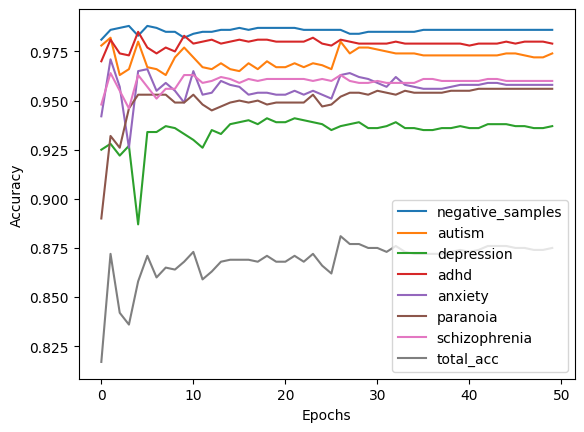

In [40]:
plot_accs(epoch_history)

In [16]:
# Free memory
import gc

model_mental_bert.cpu()
del model_mental_bert
gc.collect()
torch.cuda.empty_cache()